In [5]:
!pip install MechanicalSoup
!pip install beautifulsoup4

In [6]:
import mechanicalsoup
import requests
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import math
import random

import re
import io

import matplotlib 
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
%matplotlib inline
# functions contained in this ipynb:
'''
get_data(planet, observer,observatory,city, start, end, interval_mode, step_size, angular)
addnoise(data,mu,sigma,typ="gaussian")
sparsify(data,percent)
visibledata(planettarget, planetob,start, end, interval_mode, step_size,Rsun=1/215)
c2s(cor)
s2c(cor)
outtxt(cor,outfile)
'''

'\nget_data(planet, observer,observatory,city, start, end, interval_mode, step_size, angular)\naddnoise(data,mu,sigma,typ="gaussian")\nsparsify(data,percent)\nvisibledata(planettarget, planetob,start, end, interval_mode, step_size,Rsun=1/215)\nc2s(cor)\ns2c(cor)\nouttxt(cor,outfile)\n'

In [12]:
#this function is an application program interface(API) to online resources of HORIZON system and get the ephemeris data of planets in the solar system
def get_data(planet, observer,observatory,city, start, end, interval_mode, step_size, angular):
    print("Calling get_data function....")
    print("this function is an application program interface(API) to online resources of HORIZON system and get the ephemeris data of planets in the solar system, the units are au and au/d")
    planet_to_code = {"sun":"MB:10", "mercury":"MB:199","venus":"MB:299","earth":"MB:399","mars":"MB:499","jupiter":"MB:599",
                  "saturn":"MB:699","uranus":"MB:799","neptune":"MB:899","pluto":"MB:999"}
    observer_to_code={"sun":"@sun","earth":"500"}
    browser = mechanicalsoup.StatefulBrowser()
    url = "https://ssd.jpl.nasa.gov/horizons.cgi"
    browser.open(url)
    browser.follow_link("i?s_type=1")
    browser.select_form()
    if angular and (observer.lower()=="sun" or observer.lower()=="earth"):
        print("error, want angular coordinates but do not specify any observatory or city...")
        exit(1)
    if angular:
        browser["table_type"] = "OBSERVER"
    else:
        browser["table_type"] = "VECTORS"
    response = browser.submit_selected(btnName="set_table_type")
    browser.follow_link("i?s_target=1")
    browser.select_form()
    browser["mb_list"] = "planet"
    response = browser.submit_selected(btnName="show_mb_list")
    browser.select_form()
    browser["body"] = planet_to_code[planet.lower()]
    response = browser.submit_selected(btnName="select_body")
    browser.follow_link("i?s_loc=1")
    if observer.lower()=="sun" or observer.lower()=="earth":
        browser.select_form(nr=0)
        browser["l_str"]=observer_to_code[observer.lower()]
        browser.submit_selected(btnName="s_lookup")
    elif observer.lower()=="observatory":
        browser.select_form(nr=1)
        browser["l_list"]="obs"
        response = browser.submit_selected(btnName="s_list")
        browser.select_form()
        browser["loc_list"] = "399;{};{};".format(observatory[0],observatory[1])
        response = browser.submit_selected()
    elif observer.lower()=="city":
        browser.select_form(nr=1)
        browser["l_list"]="all"
        response = browser.submit_selected(btnName="s_list")
        browser.select_form()
        if "," in city:
            browser["loc_list"] = "399;;{};{}".format(city.split(",")[0].strip(),city.split(",")[1].strip())
        else:
            browser["loc_list"] = "399;;{};".format(city.strip())
        response = browser.submit_selected()
    browser.follow_link("i?s_time=1")
    browser.select_form()
    browser["start_time"] = start
    browser["stop_time"] = end
    browser["interval_mode"] = interval_mode
    browser["step_size"] = step_size
    response = browser.submit_selected(btnName="set_time_span")

    if angular:
        browser.follow_link("i?s_tset=1")
        browser.select_form()
        response = browser.submit_selected(btnName="preset_q_table_d")
        form = browser.select_form()
        browser["oq_4"]=1
        browser["csv_format"]="YES"
        #browser.get_current_form().print_summary()
        submit = browser.get_current_page().find(name='set_table')
        form.choose_submit(submit)
        browser.submit_selected()
    else:
        browser.follow_link("i?s_tset=1")
        browser.select_form()
        form = browser.select_form()
        browser["csv_format"]="YES"
        #browser.get_current_form().print_summary()
        submit = browser.get_current_page().find(name='set_table')
        form.choose_submit(submit)
        browser.submit_selected()
        
        
    browser.select_form()
    response = browser.submit_selected()
    s = response.text

    if angular:
        # split the string at the following regex
        # group 0 is the whole pattern, 1 is the first (), which is the header,
        # group 2 is the second (), which is the data table
        pattern = "Table format.*?:.*?Comma Separated Values.*?\*\n(.*?\n).*?\$\$SOE\n(.*?)\$\$EOE"
        #print(s)
        table_string = re.search(pattern,s,re.DOTALL)
        if table_string:
            data_string = table_string.group(1)+table_string.group(2)
            data = io.StringIO(data_string)
            df = pd.read_csv(data,sep=',')
        else:
            print('Error: could not find a data table corresponding to observation table, check your input and make sure the format is right....')
            exit(1)
        # strip the white space from the headers
        df.rename(columns=lambda x: x.strip(), inplace=True)
#         df.rename(columns={ df.columns[1]: "is_sun", 
#                            'Date__(UT)__HR:MN':'time',
#                            'Azi_(a-app)':'az',
#                            'Elev_(a-app)':'el'}, inplace = True)
#         print(df)
        df.rename(columns={ df.columns[1]: "is_sun", }, inplace = True)
        dates = df['Date__(UT)__HR:MN'].to_numpy()
        az = df['Azi_(a-app)'].to_numpy()
        el = df['Elev_(a-app)'].to_numpy()
        is_sun = df['is_sun'].to_numpy()

        return dates, az, el, is_sun
#         return df[['time','is_sun','az','el']].copy()
    
    else:
        # split the string at the following regex
        # group 0 is the whole pattern, 1 is the first (), which is the header,
        # group 2 is the second (), which is the data table
        pattern = "Reference frame.*?\*\n(.*?\n).*?\$\$SOE\n(.*?)\$\$EOE"
        #print(s)
        table_string = re.search(pattern,s,re.DOTALL)
        if table_string:
            data_string = table_string.group(1)+table_string.group(2)
            data = io.StringIO(data_string)
            df = pd.read_csv(data,sep=',')
        else:
            print('Error: could not find a data table corresponding to observation table, check your input and make sure the format is right....')
            exit(1)
        # strip the white space from the headers
        df.rename(columns=lambda x: x.strip(), inplace=True)
        #df.rename(columns={ df.columns[1]: "is_sun" }, inplace = True)
        #print(df)
        date = df["Calendar Date (TDB)"].to_numpy()
        cor = np.vstack((df.X.to_numpy(),df.Y.to_numpy(),df.Z.to_numpy())).T
        vel = np.vstack((df.VX.to_numpy(),df.VY.to_numpy(),df.VZ.to_numpy())).T
        #is_sun = df['is_sun']
        return date,cor,vel

#add noise to data, data must be in [x,y,z] format or you know what you are doing
#possible type of noise are gaussian/uniform random noise
def addnoise(data,mu,sigma,typ="gaussian"):
    ldata=np.copy(data)
    shape=np.shape(ldata)
    ldata=ldata.flatten()
    size=len(ldata)
    if typ=="gaussian":
        ldata+=np.random.normal(mu,sigma,size=size)
    elif typ=="uniform":        
        ldata+=sigma*(np.random.rand(size)-0.5+mu)
    else:
        print("invalid type of noise!")
        print("available types of noise are gaussian or uniform.")
        exit(1)
    return ldata.reshape(shape)

#randomly delete percentage of data assigned by percent
#you may want to do this to sparsify the data due random conditions like weathers, people in charge of observing ask for a day off or so.
def sparsify(data,percent):
    n=len(data)
    ndrawn=int(n*(1-percent))
    print("sparsify ",n,"data into ",n-ndrawn," data...")
    dellist=random.sample(range(n),ndrawn)
    return np.delete(data,dellist,axis=0)

#given cartesian coodinates, convert it to spherical coordinates
def c2s(cor):
    x=cor[:,0]
    y=cor[:,1]
    z=cor[:,2]
    R=np.sqrt(x**2+y**2+z**2)
    theta=np.arccos(z/R)
    phi=np.arctan2(y,x)
    cornew=np.zeros((np.shape(cor)))
    cornew[:,0]=R
    cornew[:,1]=theta
    cornew[:,2]=phi
    return cornew
#given spherical coodinates, convert it to cartesian coordinates, unit au
def s2c(cor):
    r=cor[:,0]
    theta=cor[:,1]
    phi=cor[:,2]
    x=r*np.cos(theta)
    y=r*np.sin(theta)*np.sin(phi)
    z=r*np.sin(theta)*np.cos(phi)
    cornew[:,0]=x
    cornew[:,1]=y
    cornew[:,2]=z
    return cornew
#save the data in a file
def outtxt(cor,outfile):
    print("writing output to",outfile)
    outfil=open(outfile,"w")
    for i in range(len(cor)):
        outfil.write("{:>24.9E}{:>24.9E}{:>24.9E}\n".format(cor[i,0],cor[i,1],cor[i,2]))
    outfil.close()
    print("done...")
def visibledata(planettarget, planetob,start, end, interval_mode, step_size,Rsun=1/215):
    print("visibledata function: get rid of a data point when planettarget is ahead or behind the sun as observed on planetob so that it shouldn't be visible.")
    date,corta,velta = get_data(planettarget,"sun",observatory,city, start, end, interval_mode, step_size)
    date,corob,velob = get_data(planetob,"sun",observatory,city, start, end, interval_mode, step_size)
    d=np.linalg.norm(np.cross(corta-corob,corob),axis=1)/np.linalg.norm(corta-corob,axis=1)
    idx=np.argwhere(d>Rsun)
    idx=idx.reshape(len(d))
    newdate=[date[i] for i in range(len(date)) if d[i]>Rsun]
    return newdate,corta[idx],velta[idx]   
#get the azimuth and elevation of the sun
def get_data_sun(observer,observatory,city, start, end, interval_mode, step_size):
    return get_data("sun", observer, observatory, city, start, end, interval_mode, step_size, True)

def is_sun_2_vis(is_sun,thresh):
    '''
    Function to determine whether the is_sun designation tells us that we can see the planet.
    
    Input:
        is_sun: numpy array of strings
            Holds arrays containing a string with a single space ' ', 'A', 'N', 'C', or '*'. Meanings below
        thresh:  string
            Sets the is_sun value(s) that constitute the object being visible. This is mean to reflect the fact that
            most celestial bodies are not visible to the naked eye during the day
            Designations below:
            ' ' (string of one space): Night time. Probably not useful, as this will set everything to not visible
            'A' astronautical sunrise/dusk sun is well below horizon, but is lighting up the sky somewhat
                setting this as threshold means any setting greater than or equal this (all that follow) will
                rebder the object invisible
            'N' nautical sunrise/dusk = sun is still below the horizon, but sky is lighting up
            'C' civil sunrise = sun is breaching over the horizon
            '*' daytime using this setting means planets are visisble until daytime
    '''
    if thresh == ' ':
        is_visible = np.zeros(is_sun.shape,dtype=bool)
    elif thresh == 'A':
        is_visible = ~np.isin(is_sun,['A','N','C','*'])
    elif thresh == 'N':
        is_visible = ~np.isin(is_sun,['N','C','*'])
    elif thresh == 'C':
        is_visible = ~np.isin(is_sun,['C','*'])
    else:
        is_visible = ~np.isin(is_sun,['*'])
    
    return is_visible
        
        

In [13]:
#parameters
# target planet you would like to get data of
planet = "Venus"
#available options are: "sun"(center of the sun), "earth"(center of the earth), "observatory"(observatory on the Earth), "city" (city on the Earth)
# observer="sun"
observer="city"
#if observer=="observatory" format: "[code, name]"see available options at https://ssd.jpl.nasa.gov/horizons.cgi#top
observatory=["K03", "Observatori AAS Montsec"]
#if observer=="city", then input observer's city name, See available options at https://ssd.jpl.nasa.gov/horizons.cgi#top
city = "Belize City"
#start time of collecting data format:{BC|AD} YYYY-MMM-DD {hh:mm}, {} is optional
start = "AD 1920-Oct-16"
#end time of collecting data
end = "AD 2020-Oct-16"
#time interval mode, available options are: d(day),h(hour),m(minute),Y(year),MO(month)
interval_mode = "d"
#time interval, in unit of interval_mode, currently set as 50 days
step_size = 50
#cartesian or angular data
angular=False
################################################data preprocessing
#you could choose to add gaussian or uniform noise to data
mu=0
sigma=0
#you could also choose to sparsify the data, that is randomly select percentage of the total data
percent=1

In [10]:
#get the azimuth and elevation of the sun
dates, az, el, is_sun = get_data_sun(observer,observatory,city, start, end, interval_mode, step_size)

Calling get_data function....
this function is an application program interface(API) to online resources of HORIZON system and get the ephemeris data of planets in the solar system, the units are au and au/d


In [14]:
#get the ephemeris of 6 planets and add noise, sparsify it
angular=False
date,cor,vel = get_data("Venus","sun",observatory,city, start, end, interval_mode, step_size, angular)
date,core,vele=get_data("earth","sun",observatory,city,start,end,interval_mode,step_size, angular)
date,corma,velma=get_data("Mars","sun",observatory,city,start,end,interval_mode,step_size, angular)
date,corj,velj=get_data("Jupiter","sun",observatory,city, start, end, interval_mode, step_size, angular)
date,cors,vels = get_data("Saturn","sun",observatory,city, start, end, interval_mode, step_size, angular)
date,corme,velme=get_data("Mercury","sun",observatory,city,start,end,interval_mode,step_size, angular)
noisecor=addnoise(cor,mu,sigma,typ="uniform")
sparsecor=sparsify(cor,percent)
#convert cartesian coordinates into spherical coordinates, units are : au,degree,degree
# cors=c2s(cor)
#write output file
outfile="result"
outtxt(cor,outfile)

Calling get_data function....
this function is an application program interface(API) to online resources of HORIZON system and get the ephemeris data of planets in the solar system, the units are au and au/d
Calling get_data function....
this function is an application program interface(API) to online resources of HORIZON system and get the ephemeris data of planets in the solar system, the units are au and au/d
Calling get_data function....
this function is an application program interface(API) to online resources of HORIZON system and get the ephemeris data of planets in the solar system, the units are au and au/d
Calling get_data function....
this function is an application program interface(API) to online resources of HORIZON system and get the ephemeris data of planets in the solar system, the units are au and au/d
Calling get_data function....
this function is an application program interface(API) to online resources of HORIZON system and get the ephemeris data of planets in the 

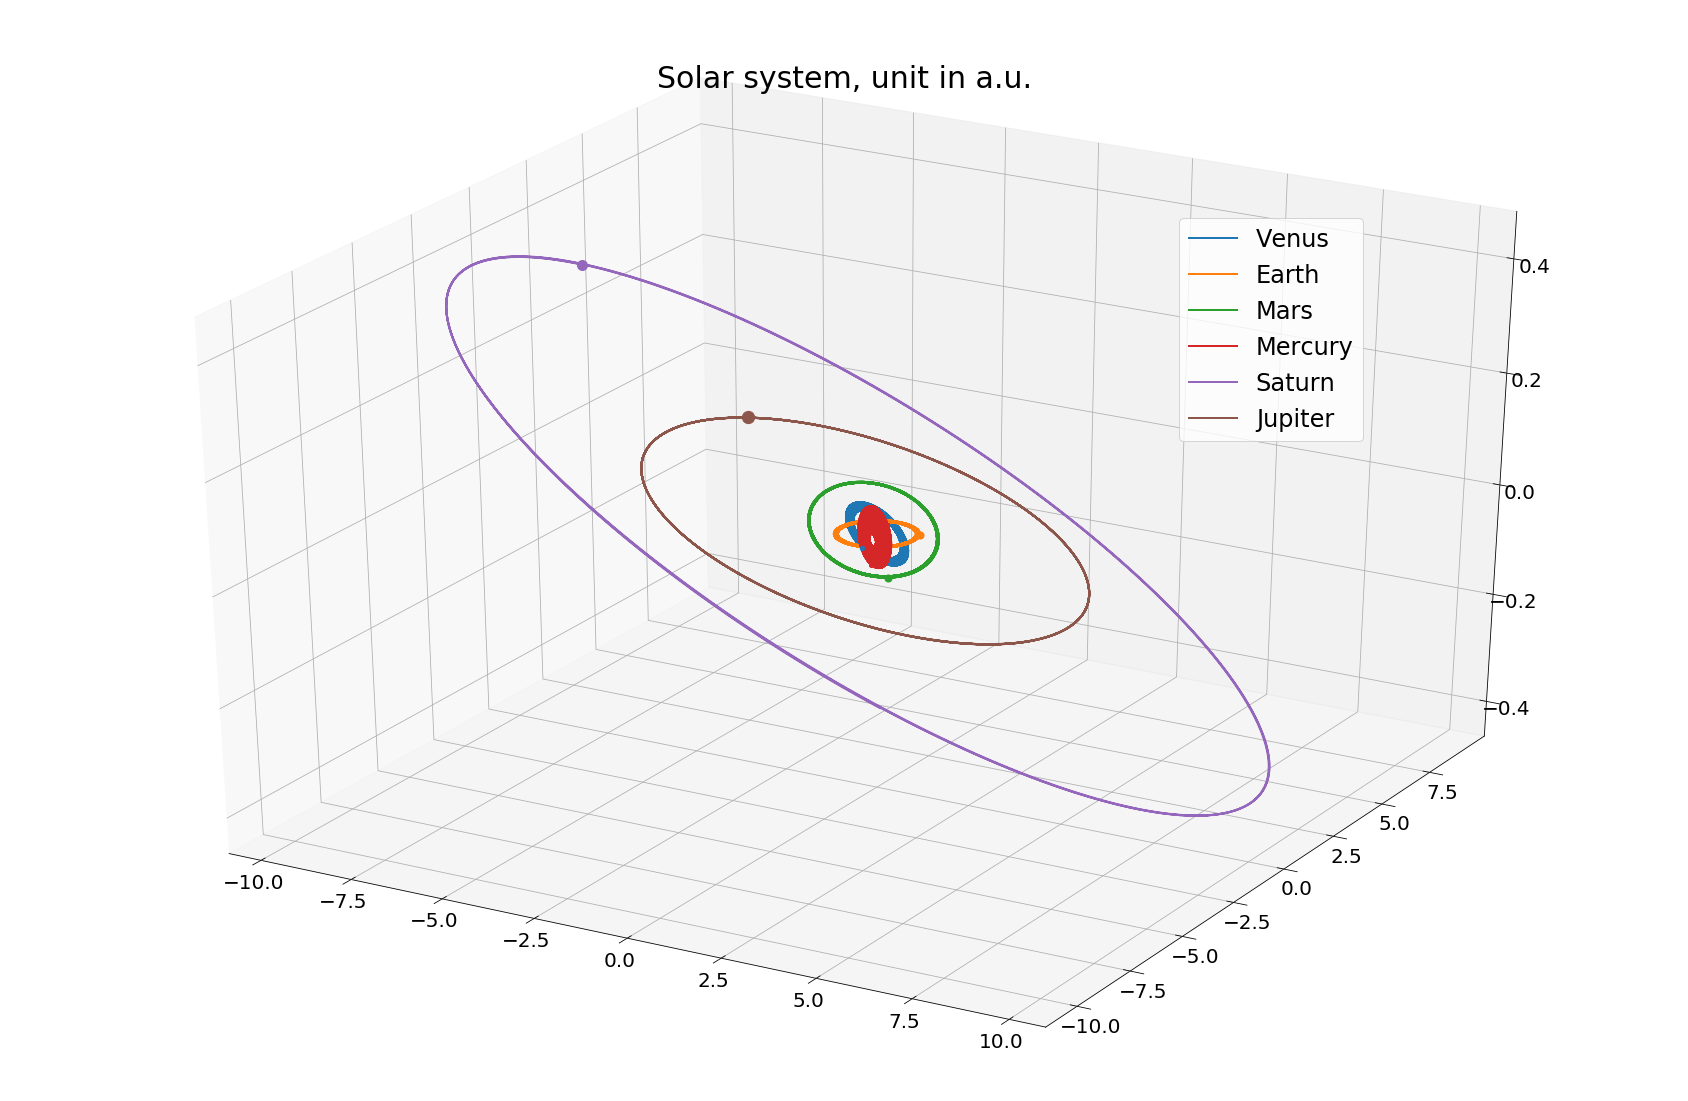

In [15]:
###########visualize the data here
fig=plt.figure(figsize=(30,20))
ax = plt.axes(projection='3d')
# Data for a three-dimensional line
#plt.plot(cor[0:200,0],cor[0:200,1])
#plt.show()
plt.title("Solar system, unit in a.u.",fontsize=30)
ax.plot3D(cor[:,0],cor[:,1],cor[:,2],lw=2,label="Venus")
ax.plot3D(core[:,0],core[:,1],core[:,2],lw=2,label="Earth")
ax.plot3D(corma[:,0],corma[:,1],corma[:,2],lw=2,label="Mars")
ax.plot3D(corme[:,0],corme[:,1],corme[:,2],lw=2,label="Mercury")
ax.plot3D(cors[:,0],cors[:,1],cors[:,2],lw=2,label="Saturn")
ax.plot3D(corj[:,0],corj[:,1],corj[:,2],lw=2,label="Jupiter")
ax.scatter(cor[0,0], cor[0,1], cor[0,2], s=20,marker='o')
ax.scatter(core[0,0], core[0,1], core[0,2],s=50, marker='o')
ax.scatter(corma[0,0], corma[0,1], corma[0,2], s=50,marker='o')
ax.scatter(corme[0,0], corme[0,1], corme[0,2], s=16,marker='o')
ax.scatter(cors[0,0], cors[0,1], cors[0,2], s=100,marker='o')
ax.scatter(corj[0,0], corj[0,1], corj[0,2], s=150,marker='o')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.zaxis.set_tick_params(labelsize=20)
#plt.zticks(fontsize=20)
ax.legend(loc=[0.7,0.6],fontsize=24)
plt.savefig("solar.png",fmt='png')

In [26]:
# plot the angular position in the sky of Venus as a function of time on a particular day

#start time of collecting data format:{BC|AD} YYYY-MMM-DD {hh:mm}
start = "AD 2020-Oct-13"
#end time of collecting data
end = "AD 2020-Oct-14"
#time interval mode, available options are: d(day),h(hour),m(minute),Y(year),MO(month)
interval_mode = "m"
#time interval, currently set as 50 days
step_size = 10

date,az,el,is_sun = get_data("Venus","city",observatory,city, start, end, interval_mode, step_size, angular=True)

Calling get_data function....
this function is an application program interface(API) to online resources of HORIZON system and get the ephemeris data of planets in the solar system, the units are au and au/d
Calling get_data function....
this function is an application program interface(API) to online resources of HORIZON system and get the ephemeris data of planets in the solar system, the units are au and au/d


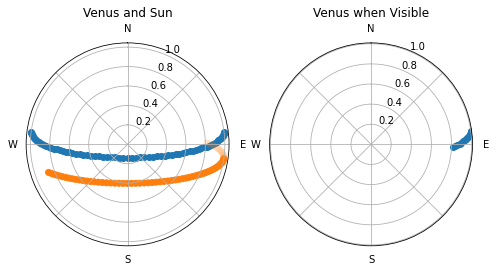

In [82]:
#plot out the trajectory of Venus and Sun on the sky viewed on Earth
flag = el>0
flag_sun = is_sun_2_vis(is_sun,'*')
#print(is_sun)
#print(flag_sun)
date_good = date[flag]
az_good = az[flag]
el_good = el[flag]

date_sun_good = date_sun[flag]
az_sun_good = az_sun[flag]
el_sun_good = el_sun[flag]

fig = plt.figure(figsize=(8, 6))
# with sun
ax = fig.add_subplot(121, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_xticklabels(['N', '', 'E', '', 'S', '', 'W', ''])

r = np.cos(np.deg2rad(el_good))
c = ax.scatter(np.deg2rad(az_good), r)
r_sun = np.cos(np.deg2rad(el_sun_good))
alpha = np.minimum((el_sun_good>0).astype('float')+.1,1)
from matplotlib.colors import to_rgb
colors = to_rgb('C1')
colors = np.tile(colors, (len(alpha),1) )
colors = np.append(colors,alpha[:,np.newaxis],axis=1)
c_sun = ax.scatter(np.deg2rad(az_sun_good), r_sun,color=colors)
ax.set_title('Venus and Sun')
ax.title.set_position([.5, 1.1])

# no sun
az_good_2 = az[flag & flag_sun]
el_good_2 = el[flag & flag_sun]
ax2 = fig.add_subplot(122, projection='polar')
ax2.set_theta_zero_location("N")
ax2.set_theta_direction(-1)
ax2.set_xticklabels(['N', '', 'E', '', 'S', '', 'W', ''])

r_2 = np.cos(np.deg2rad(el_good_2))
c = ax2.scatter(np.deg2rad(az_good_2), r_2)
ax2.set_title('Venus when Visible')
ax2.title.set_position([.5, 1.1])


In [83]:
# plot the angular position in the sky of Venus as a function of time on a particular day

#start time of collecting data format:{BC|AD} YYYY-MMM-DD {hh:mm}
start = "AD 2020-April-28"
#end time of collecting data
end = "AD 2020-April-29"
#time interval mode, available options are: d(day),h(hour),m(minute),Y(year),MO(month)
interval_mode = "m"
#time interval, currently set as 50 days
step_size = 10

date,az,el,is_sun = get_data("Venus","city",observatory,city, start, end, interval_mode, step_size, True)

Calling get_data function....
this function is an application program interface(API) to online resources of HORIZON system and get the ephemeris data of planets in the solar system, the units are au and au/d


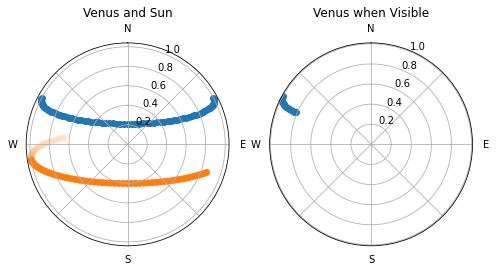

In [84]:
flag = el>0
flag_sun = is_sun_2_vis(is_sun,'*')
#print(is_sun)
#print(flag_sun)
date_good = date[flag]
az_good = az[flag]
el_good = el[flag]

date_sun_good = date_sun[flag]
az_sun_good = az_sun[flag]
el_sun_good = el_sun[flag]

fig = plt.figure(figsize=(8, 6))
# with sun
ax = fig.add_subplot(121, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_xticklabels(['N', '', 'E', '', 'S', '', 'W', ''])

r = np.cos(np.deg2rad(el_good))
c = ax.scatter(np.deg2rad(az_good), r)
r_sun = np.cos(np.deg2rad(el_sun_good))
alpha = np.minimum((el_sun_good>0).astype('float')+.1,1)
from matplotlib.colors import to_rgb
colors = to_rgb('C1')
colors = np.tile(colors, (len(alpha),1) )
colors = np.append(colors,alpha[:,np.newaxis],axis=1)
c_sun = ax.scatter(np.deg2rad(az_sun_good), r_sun,color=colors)
ax.set_title('Venus and Sun')
ax.title.set_position([.5, 1.1])

# no sun
az_good_2 = az[flag & flag_sun]
el_good_2 = el[flag & flag_sun]
ax2 = fig.add_subplot(122, projection='polar')
ax2.set_theta_zero_location("N")
ax2.set_theta_direction(-1)
ax2.set_xticklabels(['N', '', 'E', '', 'S', '', 'W', ''])

r_2 = np.cos(np.deg2rad(el_good_2))
c = ax2.scatter(np.deg2rad(az_good_2), r_2)
ax2.set_title('Venus when Visible')
ax2.title.set_position([.5, 1.1])

In [97]:
# plot the angular position in the sky of Venus as a function of time on a particular day

#start time of collecting data format:{BC|AD} YYYY-MMM-DD {hh:mm}
start = "AD 2020-June-06"
#end time of collecting data
end = "AD 2020-June-07"
#time interval mode, available options are: d(day),h(hour),m(minute),Y(year),MO(month)
interval_mode = "m"
#time interval, currently set as 50 days
step_size = 10

date,az,el,is_sun = get_data("Venus","city",observatory,city, start, end, interval_mode, step_size, True)

Calling get_data function....
this function is an application program interface(API) to online resources of HORIZON system and get the ephemeris data of planets in the solar system, the units are au and au/d


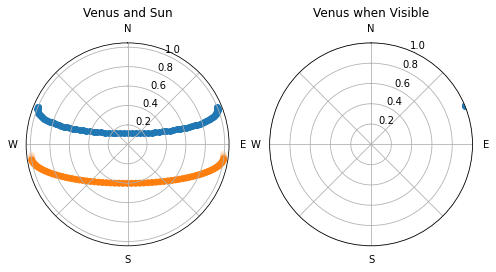

In [98]:
flag = el>0
flag_sun = is_sun_2_vis(is_sun,'*')
#print(is_sun)
#print(flag_sun)
date_good = date[flag]
az_good = az[flag]
el_good = el[flag]

date_sun_good = date_sun[flag]
az_sun_good = az_sun[flag]
el_sun_good = el_sun[flag]

fig = plt.figure(figsize=(8, 6))
# with sun
ax = fig.add_subplot(121, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_xticklabels(['N', '', 'E', '', 'S', '', 'W', ''])

r = np.cos(np.deg2rad(el_good))
c = ax.scatter(np.deg2rad(az_good), r)
r_sun = np.cos(np.deg2rad(el_sun_good))
alpha = np.minimum((el_sun_good>0).astype('float')+.1,1)
from matplotlib.colors import to_rgb
colors = to_rgb('C1')
colors = np.tile(colors, (len(alpha),1) )
colors = np.append(colors,alpha[:,np.newaxis],axis=1)
c_sun = ax.scatter(np.deg2rad(az_sun_good), r_sun,color=colors)
ax.set_title('Venus and Sun')
ax.title.set_position([.5, 1.1])

# no sun
az_good_2 = az[flag & flag_sun]
el_good_2 = el[flag & flag_sun]
ax2 = fig.add_subplot(122, projection='polar')
ax2.set_theta_zero_location("N")
ax2.set_theta_direction(-1)
ax2.set_xticklabels(['N', '', 'E', '', 'S', '', 'W', ''])

r_2 = np.cos(np.deg2rad(el_good_2))
c = ax2.scatter(np.deg2rad(az_good_2), r_2)
ax2.set_title('Venus when Visible')
ax2.title.set_position([.5, 1.1])